CONTEXTE : Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

OBJECTIF : vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

NB : Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)


TO DO :
En + : Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.


CONSEILS :
L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données / DATA LEAKS). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

#### Features to predict :

##### Energy Use :

- **SourceEUI(kBtu/sf)** : Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.


- **SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy.

- **SteamUse(kBtu)** : The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).

- **Electricity(kBtu)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).

- **NaturalGas(kBtu)** : The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).

##### Greenhouse Gas Emissions :

- **TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.


### Importing libraries

In [119]:
%reset -f

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


# PART 1 : Cleaning dataset

### 1) Visualizing dataset

#### 1.1) Global statistics

What's in this Dataset?
Rows : 3,376
Columns : 46
Each row is a : Building



source : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [120]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# load raw dataset
#all_data = pd.read_csv("dataset/2016_Building_Energy_Benchmarking.csv", sep = ',', encoding = 'utf-8')
raw_data = pd.read_csv("dataset/2016_Building_Energy_Benchmarking.csv")

display(raw_data)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00,0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,756493.00,NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.57,-122.31,1990,1.00,1,12294,0,12294,Office,Office,12294.00,NaN,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.60,-122.32,2004,1.00,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.64,-122.36,1974,1.00,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Cen

In [121]:
# Primary Key : OSEBuilding ID
raw_data["OSEBuildingID"].unique().shape

(3376,)

In [122]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [123]:
raw_data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.00,3376.00,3360.00,3376.00,3376.00,3376.00,3376.00,3368.00,3376.00,3376.00,3376.00,3376.00,3356.00,1679.00,596.00,2533.00,3369.00,3370.00,3367.00,3367.00,3371.00,3370.00,3367.00,3367.00,3367.00,3367.00,3367.00,0.00,3367.00,3367.00
mean,21208.99,2016.00,98116.95,4.44,47.62,-122.33,1968.57,1.11,4.71,94833.54,8001.53,86832.01,79177.64,28444.08,11738.68,67.92,54.73,57.03,134.23,137.78,5403667.29,5276725.71,274595.90,1086638.97,3707612.16,13685.05,1368504.54,NaN,119.72,1.18
std,12223.76,0.00,18.62,2.12,0.05,0.03,33.09,2.11,5.49,218837.61,32326.72,207939.81,201703.41,54392.92,29331.20,26.87,56.27,57.16,139.29,139.11,21610628.63,15938786.48,3912173.39,4352478.36,14850656.14,67097.81,6709780.83,NaN,538.83,1.82
min,1.00,2016.00,98006.00,1.00,47.50,-122.41,1900.00,0.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,1.00,0.00,0.00,0.00,-2.10,0.00,0.00,0.00,-33826.80,-115417.00,0.00,0.00,NaN,-0.80,-0.02
25%,19990.75,2016.00,98105.00,3.00,47.60,-122.35,1948.00,1.00,2.00,28487.00,0.00,27756.00,25094.75,5000.00,2239.00,53.00,27.90,29.40,74.70,78.40,925128.59,970182.23,0.00,187422.95,639487.00,0.00,0.00,NaN,9.50,0.21
50%,23112.00,2016.00,98115.00,4.00,47.62,-122.33,1975.00,1.00,4.00,44175.00,0.00,43216.00,39894.00,10664.00,5043.00,75.00,38.60,40.90,96.20,101.10,1803753.25,1904452.00,0.00,345129.91,1177583.00,3237.54,323754.00,NaN,33.92,0.61
75%,25994.25,2016.00,98122.00,7.00,47.66,-122.32,1997.00,1.00,5.00,90992.00,0.00,84276.25,76200.25,26640.00,10138.75,90.00,60.40,64.28,143.90,148.35,4222455.25,4381429.12,0.00,829317.84,2829632.50,11890.33,1189033.50,NaN,93.94,1.37
max,50226.00,2016.00,98272.00,7.00,47.73,-122.22,2015.00,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,686750.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,NaN,16870.98,34.09


#### 1.2) Visualizing building types

In [124]:
all_data = raw_data.copy()

all_building_types = all_data["BuildingType"].unique().tolist()
print(all_building_types, end='\n\n')

all_primary_types = all_data["PrimaryPropertyType"].unique().tolist()
print(all_primary_types, end='\n\n')

all_largest_property_use_type = all_data["LargestPropertyUseType"].unique().tolist()
print(all_largest_property_use_type, end='\n\n')

['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)', 'Nonresidential WA']

['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily', 'Office']

['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School', 'College/University', 'Automobile Dealership', 'Office', 'Self-Storage Facility', 'Non-Refrigerated Warehouse', 'Other - Mall', 'Senior Care Community', 'Medical Office', 'Retail S

In [125]:
# we choose the buildings that are used for living purposes.
building_types_to_drop = ["Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)"]

# we only keep the buildings that have a non-residential utilisation
buildings_to_drop = all_data[all_data["BuildingType"].isin(building_types_to_drop)]

# checking the building type of the buildings to drop
a = buildings_to_drop[["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType"]]
l = []
for index, row in a.iterrows():
    x = str(row["BuildingType"]) + " ; " + str(row["PrimaryPropertyType"]) + " ; " + str(row["LargestPropertyUseType"])
    l.append(x)

b = set(l)
len(b)
b

{'Multifamily HR (10+) ; High-Rise Multifamily ; Multifamily Housing',
 'Multifamily HR (10+) ; High-Rise Multifamily ; nan',
 'Multifamily HR (10+) ; Hotel ; Hotel',
 'Multifamily HR (10+) ; Other ; Other',
 'Multifamily HR (10+) ; Senior Care Community ; Senior Care Community',
 'Multifamily LR (1-4) ; Low-Rise Multifamily ; Multifamily Housing',
 'Multifamily LR (1-4) ; Low-Rise Multifamily ; nan',
 'Multifamily LR (1-4) ; Mid-Rise Multifamily ; Multifamily Housing',
 'Multifamily LR (1-4) ; Mixed Use Property ; Multifamily Housing',
 'Multifamily LR (1-4) ; Mixed Use Property ; Self-Storage Facility',
 'Multifamily LR (1-4) ; Mixed Use Property ; Senior Care Community',
 'Multifamily LR (1-4) ; Other ; Other',
 'Multifamily LR (1-4) ; Other ; Other - Lodging/Residential',
 'Multifamily LR (1-4) ; Senior Care Community ; Senior Care Community',
 'Multifamily LR (1-4) ; Small- and Mid-Sized Office ; Office',
 'Multifamily LR (1-4) ; University ; College/University',
 'Multifamily MR 

#### 1.2) Removing building used for living purposes.

In [126]:
print(all_primary_types, end='\n\n')

['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily', 'Office']



In [127]:
#building_types_to_drop = ["Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)"]
primary_property_type_to_drop = ["Mid-Rise Multifamily", "Senior Care Community", "Residence Hall", "Low-Rise Multifamily", "High-Rise Multifamily"]
largest_property_use_type_to_drop = ["Other - Lodging/Residential"]

print("We don't use the BuildingType since the use of building can be an office even if the building type is a Multifamily building.")
#test = all_data[all_data["PrimaryPropertyType"].isin(primary_property_type_to_drop) | all_data["LargestPropertyUseType"].isin(largest_property_use_type_to_drop)]
test = all_data[~all_data["PrimaryPropertyType"].isin(primary_property_type_to_drop)]
"Multifamily Housing", "Senior Care Community", "Other - Lodging/Residential", "Residence Hall/Dormitory", "Residential Care Facility"

l = []
for index, row in test.iterrows():
    x = str(row["BuildingType"]) + " ; " + str(row["PrimaryPropertyType"]) + " ; " + str(row["LargestPropertyUseType"])
    l.append(x)

b = set(l)
len(b)
b

We don't use the BuildingType since the use of building can be an office even if the building type is a Multifamily building.


{'Campus ; K-12 School ; K-12 School',
 'Campus ; Large Office ; Office',
 'Campus ; Mixed Use Property ; Office',
 'Campus ; Mixed Use Property ; Parking',
 'Campus ; Mixed Use Property ; Retail Store',
 'Campus ; Other ; Adult Education',
 'Campus ; Other ; Manufacturing/Industrial Plant',
 'Campus ; Other ; Other',
 'Campus ; Restaurant ; Restaurant',
 'Campus ; University ; College/University',
 'Multifamily HR (10+) ; Hotel ; Hotel',
 'Multifamily HR (10+) ; Other ; Other',
 'Multifamily LR (1-4) ; Mixed Use Property ; Multifamily Housing',
 'Multifamily LR (1-4) ; Mixed Use Property ; Self-Storage Facility',
 'Multifamily LR (1-4) ; Mixed Use Property ; Senior Care Community',
 'Multifamily LR (1-4) ; Other ; Other',
 'Multifamily LR (1-4) ; Other ; Other - Lodging/Residential',
 'Multifamily LR (1-4) ; Small- and Mid-Sized Office ; Office',
 'Multifamily LR (1-4) ; University ; College/University',
 'Multifamily MR (5-9) ; Mixed Use Property ; Multifamily Housing',
 'Multifamily

In [128]:

# we only keep the buildings that have a non-residential utilisation
all_data_v11 = all_data[~all_data["BuildingType"].isin(building_types_to_drop)]

all_data_v11.shape

all_data_v11.describe()

predict = ["TotalGHGEmissions", ""]
# exploration : matrice corrélation et corrélation entre categorielles et quantitatives (GHGE corrélé avec var consom E (elctricity, steam etc)
# predict : consomation bat puis avec ca predire l'emission CO2
# 1) prediction consommation sur l'énergie puis predire CO2 (le + long le +complexe)
# categories batiments mal ecrites / numeriques incohérentes

In [129]:
a = all_data_v11["BuildingType"].unique().tolist()
print(a, end='\n\n')

b = all_data_v11["PrimaryPropertyType"].unique().tolist()
print(b, end='\n\n')

c = all_data_v11["LargestPropertyUseType"].unique()
print(c, end='\n\n')

['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

['Hotel', 'Other', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily', 'Office']

['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'K-12 School' 'College/University'
 'Automobile Dealership' 'Office' 'Self-Storage Facility'
 'Non-Refrigerated Warehouse' 'Other - Mall' 'Senior Care Community'
 'Medical Office' 'Retail Store' 'Hospital (General Medical & Surgical)'
 'Museum' 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dor

### 2) Filling ZipCode with k-NN

19 unique neighborhoods, but because of upper case / lower case we get 14 neighborhoods.
We will use CouncilDistrictCode and ZipCode to localize the buildings.

About the localization of the buildings, we will use the ZipCode, however we have 16 missing values, we tried to fill them with a k-NN.


#### 2.1) Preparing ZipCode data

In [130]:
all_zipcode = all_data["ZipCode"].unique().tolist()
print("We have :", len(all_zipcode), "unique zipcodes.")

# DataFrame with 16 missing ZipCodes
zipcode_na_df = all_data[all_data["ZipCode"].isna()]
print("We have :", zipcode_na_df.shape[0], "missing ZipCodes.")

# We make a list with the address of the building for which the ZipCode is missing.
zipcode_na_list_address = zipcode_na_df["Address"].tolist()
zipcode_na_list = [[i, ""] for i in zipcode_na_list_address]

We have : 56 unique zipcodes.
We have : 16 missing ZipCodes.


In [131]:
# This is the list of zipcodes for each of the 16 missing zipcode. We found it on searching on internet using the Address
correct_zipcode = [98125, 98144, 98117, 98125, 98107, 98117, 98119, 98112, 98122, 98118, 98126, 98108, 98104, 98119, 98108, 98108]
#print(len(right_zipcode))

for i, zipcode in enumerate(correct_zipcode):
    zipcode_na_list[i][1] = zipcode

print(zipcode_na_list)

[['10510 5th Ave NE', 98125], ['405 MLK Jr Way S', 98144], ['8729 15th Ave NW', 98117], ['2806 NE 127th St', 98125], ['6020 28th ave NW', 98107], ['1471 NW 67th St', 98117], ['1403 w howe', 98119], ['1400 E Galer St', 98112], ['2323 East Cherry St', 98122], ['4420 S Genesee', 98118], ['6920 34th Ave SW', 98126], ['1600 S Dakota St', 98108], ['719 8th Ave S', 98104], ['1920 1st Ave W', 98119], ['8319 8th Ave S', 98108], ['2820 S Myrtle St', 98108]]


#### 2.2) ZipCode k-NN

In [132]:
# K-NN

# 0) data / target
zipcode_not_na = all_data[~all_data["ZipCode"].isna()]

target = zipcode_not_na["ZipCode"]
display(target.shape)

X = zipcode_not_na[["Latitude", "Longitude", "CouncilDistrictCode"]]
display(X.shape)

# 1) Sampling
from sklearn.model_selection import train_test_split
# X = data and y = target
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8)

(3360,)

(3360, 3)

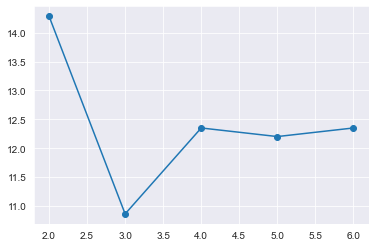

In [133]:
# 2) k-NN and evaluation
from sklearn import neighbors

# Loop on several models ! and check for which value of the hyperparameter k we get the least error percentage.
errors = []
k_start, k_end = 2, 7
for k in range(k_start, k_end):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    # We "fit" the model to our training data and compute the percentage of correct predictions with "score"
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(k_start, k_end), errors, 'o-')
plt.show()

In [134]:
# 3) predict !!
# We use the best classifier to predict
k = 3
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

X_pred = zipcode_na_df[["Latitude", "Longitude", "CouncilDistrictCode"]] # 16 missing postal code
correct_target = np.array(correct_zipcode, dtype=np.float64) # 16 correct ZipCodes / dtype so that it won't be int32

y_pred = knn.predict(X_pred)
print(y_pred)
print(correct_target)

# Accuracy of what X_pred predicted (y_pred) and correct_targer
knn.score(X_pred, correct_target)
# Accuracy 14/16 = 0.875, means two wrong predictions.
# Accuracy 15/16 = 0.9375, means one wrong prediction. ;) with CouncilDistrict we get better results ;)

error = 1 - knn.score(X_pred, correct_target)
print('Error in prediction : %.3f' % error) # .1 means 1 decimal, .2 means 2 decimals
print('Error in prediction : {:.1%}'.format(error))

[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98112. 98122. 98118.
 98126. 98144. 98104. 98109. 98108. 98108.]
[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98112. 98122. 98118.
 98126. 98108. 98104. 98119. 98108. 98108.]
Error in prediction : 0.125
Error in prediction : 12.5%


In [135]:
print("We replace the missing ZipCodes by their correct value.")

#zipcode_na_df.index
# We iterate on the index of the buildings for which the ZipCode is missing
all_data_v1 = all_data.copy()
for i, index in enumerate(zipcode_na_df.index):
    all_data_v1.at[index, "ZipCode"] = correct_zipcode[i]

# Verification
#all_data_v1["ZipCode"].describe()
#display(all_data_v1[all_data_v1["ZipCode"].isna()])


We replace the missing ZipCodes by their correct value.


### 3) Dropping features

We have 46 columns / features.

We select the interesting features that will help us predict the energy consumption of the buildings.

In [136]:
columns_to_drop = ["PropertyName", "ListOfAllPropertyUseTypes", "Address", "City", "State", "TaxParcelIdentificationNumber", "Neighborhood", "YearsENERGYSTARCertified", "DefaultData", "Comments", "ComplianceStatus", "Latitude", "Longitude"]

print("We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.")

We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.


In [137]:
all_data_v1 = all_data_v1.drop(columns=columns_to_drop)
display(all_data_v1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,98101.00,7,1927,1.00,12,88434,0,88434,Hotel,88434.00,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,98101.00,7,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,98101.00,7,1969,1.00,41,956110,196718,759392,Hotel,756493.00,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,98101.00,7,1926,1.00,10,61320,0,61320,Hotel,61320.00,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,98121.00,7,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,98108.00,2,1990,1.00,1,12294,0,12294,Office,12294.00,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,98104.00,2,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,98119.00,7,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,98108.00,1,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,NaN,22.11,1.57


### 4) Verifying GFA

In [138]:
# df = all_data[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
# df.describe()

def verify_PropertyGFA(data_frame):
    """

    :param data_frame:
    :return:

    :UC: 100% filled df[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
    """
    df = data_frame.copy()
    df = df[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
    for index, row in df.iterrows():
        if row["PropertyGFATotal"] != row["PropertyGFABuilding(s)"] + row["PropertyGFAParking"]:
            print("HERE : ", index, row)
    print("End of checking.")

verify_PropertyGFA(all_data_v1)


End of checking.


We have checked that the Total Property GFA is equal to the Total Building(s) GFA + Total Parking GFA.

### 5) Verifying Property Use Type

In [139]:
def fill_property_use_type_GFA(data_frame):
    """

    :param data_frame:
    :return:
    """
    # 1) dropna for LargestPropertyUseTypeGFA
    rows_to_drop = data_frame[data_frame["LargestPropertyUseTypeGFA"].isna()]
    index_to_drop = rows_to_drop.index

    # 2) we drop all the rows for which we have a NaN for LargestPropertyUseTypeGFA
    df = data_frame.copy()
    df = df.drop(index=index_to_drop)

    # 3) We fill the NaN for SecondLargestPropertyUseTypeGFA and ThirdLargestPropertyUseTypeGFA
    df["SecondLargestPropertyUseTypeGFA"] = df["SecondLargestPropertyUseTypeGFA"].fillna(0)
    df["ThirdLargestPropertyUseTypeGFA"] = df["ThirdLargestPropertyUseTypeGFA"].fillna(0)

    df["SecondLargestPropertyUseType"] = df["SecondLargestPropertyUseType"].fillna("None")
    df["ThirdLargestPropertyUseType"] = df["ThirdLargestPropertyUseType"].fillna("None")

    return df

all_data_v2 = fill_property_use_type_GFA(all_data_v1)

display(all_data_v2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,98101.00,7,1927,1.00,12,88434,0,88434,Hotel,88434.00,None,0.00,None,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,98101.00,7,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,98101.00,7,1969,1.00,41,956110,196718,759392,Hotel,756493.00,None,0.00,None,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,98101.00,7,1926,1.00,10,61320,0,61320,Hotel,61320.00,None,0.00,None,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,98121.00,7,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,98108.00,2,1990,1.00,1,12294,0,12294,Office,12294.00,None,0.00,None,0.00,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,98104.00,2,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,None,0.00,None,0.00,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,98119.00,7,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,98108.00,1,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,NaN,22.11,1.57


We have filled Second and Third Property Use Type GFA by 0 (meaning there are no second or  third use for the building.
We have also filled the Second and Third Property USe Type by "None".

### 6) Outliers cleaning

#### 1) outliers described in the dataset

Outlier : Whether a property is a high or low outlier

In [140]:
# We have a column called "Outlier" in which we have 32 buildings which are considered outliers.
outliers_examples = all_data_v2[~all_data_v2["Outlier"].isna()]

display(outliers_examples)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,98101.00,7,1958,1.00,6,172842,25920,146922,Office,99890.00,Data Center,39336.00,Parking,25000.00,NaN,297.40,299.20,909.60,911.50,41399504.00,41650404.00,0.00,11663150.00,39794668.00,16048.31,1604831.00,High outlier,362.66,2.10
384,539,2016,NonResidential,Retail Store,98105.00,4,1987,1.00,2,69492,0,69492,Retail Store,69800.00,Other,0.00,None,0.00,100.00,4.60,4.60,14.30,14.30,318962.81,318962.81,0.00,93482.60,318963.00,0.00,0.00,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,98104.00,2,1913,5.00,7,154159,0,154159,Office,193154.00,None,0.00,None,0.00,100.00,58.00,58.80,28.00,28.70,11195917.00,11348758.00,0.00,471503.00,1608768.00,3430.50,343050.00,Low outlier,29.43,0.19
517,704,2016,NonResidential,Large Office,98119.00,7,2000,1.00,4,129551,42500,87051,Office,82273.00,Parking,42500.00,Data Center,4778.00,1.00,311.70,311.70,978.90,978.90,27137190.00,27137190.00,0.00,7953454.50,27137187.00,0.00,0.00,High outlier,189.18,1.46
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,98121.00,7,1982,1.00,24,167941,0,167941,Multifamily Housing,138787.00,Parking,99952.00,Swimming Pool,0.00,100.00,17.30,18.70,50.40,54.00,2407904.50,2589125.50,0.00,626561.62,2137828.00,2700.76,270076.00,Low outlier,29.25,0.17
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,98102.00,3,1989,1.00,4,31702,0,31702,Multifamily Housing,26418.00,Parking,14280.00,None,0.00,NaN,9.70,10.40,30.40,32.70,255971.20,275412.00,0.00,75020.90,255971.00,0.00,0.00,Low outlier,1.78,0.06
839,19967,2016,SPS-District K-12,K-12 School,98109.00,7,2001,1.00,1,35805,0,35805,K-12 School,35805.00,None,0.00,None,0.00,100.00,12.10,12.10,27.00,27.00,431471.69,431471.69,0.00,72282.40,246628.00,1848.44,184844.00,Low outlier,11.54,0.32
962,20367,2016,Multifamily LR (1-4),Low-Rise Multifamily,98126.00,1,1990,1.00,3,70207,0,70207,Multifamily Housing,71273.00,None,0.00,None,0.00,100.00,9.90,9.90,30.90,30.90,702481.38,702481.38,0.00,205885.50,702481.00,0.00,0.00,Low outlier,4.90,0.07
1045,20617,2016,NonResidential,Retail Store,98134.00,2,1953,1.00,1,39900,0,39900,Retail Store,25000.00,Non-Refrigerated Warehouse,15000.00,None,0.00,100.00,3.60,3.60,6.40,6.40,145468.80,145468.80,0.00,14362.50,49005.00,964.64,96464.00,Low outlier,5.46,0.14
1229,21315,2016,NonResidential,Small- and Mid-Sized Office,98101.00,7,1903,1.00,3,57720,0,57720,Office,25000.00,None,0.00,None,0.00,NaN,1.00,1.00,3.00,3.00,24105.50,24105.50,0.00,7064.90,24105.00,0.00,0.00,Low outlier,0.17,0.00


In [141]:

all_data_v3 = all_data_v2[all_data_v2["Outlier"].isna()]
print("Before removing the 32 outliers :", all_data_v2.shape, "After removing them :", all_data_v3.shape)

print("Should I use them as a reference for outliers ??")

Before removing the 32 outliers : (3356, 33) After removing them : (3324, 33)
Should I use them as a reference for outliers ??


#### 2) Outliers (negative electricity or gas)

In [142]:
all_data_v3.describe()
print(all_data_v3.shape)

all_data_v4 = all_data_v3[all_data_v3["SourceEUIWN(kBtu/sf)"] >= 0]

print("We had one outlier building for which the energy values were negative.")
print("Theses features were negative : SourceEUIWN(kBtu/sf), Electricity(kWh), Electricity(kBtu), TotalGHGEmissions, GHGEmissionsIntensity")

display(all_data_v4.describe())

(3324, 33)
We had one outlier building for which the energy values were negative.
Theses features were negative : SourceEUIWN(kBtu/sf), Electricity(kWh), Electricity(kBtu), TotalGHGEmissions, GHGEmissionsIntensity


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,2502.00,3321.00,3322.00,3323.00,3323.00,3323.00,3322.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00,3323.00
mean,21166.83,2016.00,98117.01,4.45,1968.72,1.11,4.71,95508.98,8098.97,87410.01,79499.11,14291.30,2094.11,67.87,54.81,57.12,134.29,137.85,5429792.77,5299459.54,275612.34,1090670.61,3721368.11,13765.36,1376535.75,120.32,1.18
std,12234.36,0.00,18.68,2.12,33.01,2.12,5.52,220443.84,32562.02,209477.65,202640.47,41167.30,13199.41,26.69,56.02,56.90,137.99,137.75,21746864.60,16027066.83,3935155.39,4374636.63,14926260.19,67501.66,6750165.94,542.09,1.82
min,1.00,2016.00,98006.00,1.00,1900.00,0.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19981.00,2016.00,98105.00,3.00,1948.50,1.00,2.00,28515.50,0.00,27790.00,25148.50,0.00,0.00,53.00,28.10,29.50,75.00,78.70,936835.34,986452.22,0.00,188824.25,644268.50,0.00,0.00,9.67,0.21
50%,23104.00,2016.00,98115.00,4.00,1975.00,1.00,4.00,44432.00,0.00,43330.00,39960.00,0.00,0.00,75.00,38.80,41.00,96.40,101.30,1813285.25,1917764.56,0.00,346457.00,1182111.00,3306.09,330609.00,34.15,0.62
75%,25985.00,2016.00,98122.00,7.00,1997.00,1.00,5.00,91580.00,0.00,84744.50,76902.50,10765.50,0.00,90.00,60.40,64.30,143.90,148.35,4225117.50,4383888.88,0.00,831021.78,2835446.00,11942.90,1194290.00,94.12,1.37
max,50226.00,2016.00,98272.00,7.00,2015.00,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,686750.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,16870.98,34.09


Kindergarten through high school (K–12) buildings in the US use an average of 10 kilowatt-hours ( kWh ) of electricity and 50 cubic feet of natural gas per square foot ( ft2 ) annually.

In [143]:
all_data_v4[all_data_v4["Electricity(kWh)"] < 10]
print("WEIRD ?? ASK MENTOR")
# MENTOR : verifier la coherence des données (EUI = Electricity + gas + steam ? check somme envirion egale (ecart < 1% / puis les ocrriger les variables ou exlcure

WEIRD ?? ASK MENTOR


#### 3) Removing buildings with NaN values

In [144]:
print("We remove 2 buildings with SiteEUI(kBtu/sf)")
print("# We remove 1 building with SiteEUIWN(kBtu/sf)")

all_data_v5 = all_data_v4.dropna(subset=["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)"])
display(all_data_v5)

We remove 2 buildings with SiteEUI(kBtu/sf)
# We remove 1 building with SiteEUIWN(kBtu/sf)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,98101.00,7,1927,1.00,12,88434,0,88434,Hotel,88434.00,None,0.00,None,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,98101.00,7,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,98101.00,7,1969,1.00,41,956110,196718,759392,Hotel,756493.00,None,0.00,None,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,98101.00,7,1926,1.00,10,61320,0,61320,Hotel,61320.00,None,0.00,None,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,98121.00,7,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,98108.00,2,1990,1.00,1,12294,0,12294,Office,12294.00,None,0.00,None,0.00,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,98104.00,2,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,None,0.00,None,0.00,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,98119.00,7,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,98108.00,1,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,NaN,22.11,1.57


In [145]:
print("Last but not least : ENERGYSTARScore and its NaN :")
#all_data_v5["ENERGYSTARScore"].describe()
all_data_v6 = all_data_v5["ENERGYSTARScore"].fillna(-1)

all_data_v6.describe()
print("?? ASK MENTOR")

Last but not least : ENERGYSTARScore and its NaN :
?? ASK MENTOR


In [146]:
# 90% laisser mais pas l'utiliser au debut
# projet : determiner si l'Energie star score / pour l'instant

### 7) Plot kWh and kBtu and drop

In [147]:
data = all_data_v6
#data.plot.scatter("Electricity(kWh)", "Electricity(kBtu)", c="CouncilDistrictCode", colormap='viridis')
#data.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)", c="CouncilDistrictCode", colormap='viridis')

data.plot.scatter("Electricity(kWh)", "Electricity(kBtu)")
data.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)")

ValueError: plot kind scatter can only be used for data frames

In [ ]:
print("After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.")
all_data_v7 = all_data_v6.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

In [ ]:
x = all_data_v5[all_data_v5["Electricity(kBtu)"] > 600000000]
display(x)
print("HEYY HOW SHOULD I REMOVE OUTLIERS ?? ASK MENTOR")
# 1) identifier  le nombre de batiment impacté / equilibre / pas de seuil mais s'assurer de ne pas perdre trop de batiments.


# PART 2 : Exploration of the dataset

In [ ]:
dataset = pd.read_csv("dataset/2016_Building_Energy_Cleaned.csv")

#### 2) Outliers (negative electricity or gas)

In [ ]:
all_data_v3.describe()
print(all_data_v3.shape)

all_data_v4 = all_data_v3[all_data_v3["SourceEUIWN(kBtu/sf)"] >= 0]

print("We had one outlier building for which the energy values were negative.")
print("Theses features were negative : SourceEUIWN(kBtu/sf), Electricity(kWh), Electricity(kBtu), TotalGHGEmissions, GHGEmissionsIntensity")

display(all_data_v4.describe())

Kindergarten through high school (K–12) buildings in the US use an average of 10 kilowatt-hours ( kWh ) of electricity and 50 cubic feet of natural gas per square foot ( ft2 ) annually.

In [ ]:
all_data_v4[all_data_v4["Electricity(kWh)"] < 10]
print("WEIRD ?? ASK MENTOR")

#### 3) Removing buildings with NaN values

In [ ]:
print("We remove 2 buildings with SiteEUI(kBtu/sf)")
print("# We remove 1 building with SiteEUIWN(kBtu/sf)")

all_data_v5 = all_data_v4.dropna(subset=["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)"])
display(all_data_v5)

In [ ]:
print("Last but not least : ENERGYSTARScore and its NaN :")
#all_data_v5["ENERGYSTARScore"].describe()
all_data_v6 = all_data_v5["ENERGYSTARScore"].fillna(-1)

all_data_v6.describe()
print("?? ASK MENTOR")

### 7) Plot kWh and kBtu and drop

In [ ]:
data = all_data_v6
#data.plot.scatter("Electricity(kWh)", "Electricity(kBtu)", c="CouncilDistrictCode", colormap='viridis')
#data.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)", c="CouncilDistrictCode", colormap='viridis')

data.plot.scatter("Electricity(kWh)", "Electricity(kBtu)")
data.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)")

In [ ]:
print("After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.")
all_data_v7 = all_data_v6.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

In [ ]:
x = all_data_v5[all_data_v5["Electricity(kBtu)"] > 600000000]
display(x)
print("HEYY HOW SHOULD I REMOVE OUTLIERS ?? ASK MENTOR")


# PART 2 : Exploration of the dataset

### TODO :
1) delete outliers using the 32 outlier (electricty < 5 etc)

3) Property type (12) to numbers ?? (graph and cross data !!!)
4) graphs (scatter plots, boxplot, describe, correlation matrix)

In [ ]:
dataset = pd.read_csv("dataset/2016_Building_Energy_Cleaned.csv")

# matrice corr
# distribution


# nettoyer : filtrer en ligne / quelques graphiques pour la presentation et mieux visualier / pour justifier des filtres

# exploration : features et var à prédire / matrice de corr / gtaphiques de distribution (var categorielles)

# à la fin du premier notebook / csv : bat propres et colonnes pour prediction

# 1) notebook par var à predire (tres propres et exaustif) : MAX TEMPS
# 2) dupliquer

# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire



In [ ]:
print("Source Energy Accounts for Total Energy Use")
features_to_predict = [
    "SourceEUI(kBtu/sf)",
"SiteEnergyUse(kBtu)",
"SteamUse(kBtu)",
"Electricity(kBtu)",
"NaturalGas(kBtu)",
"TotalGHGEmissions"]

print("Features to predict : ", features_to_predict)